In [1]:
import numpy as np
import higra as hg
import imageio
import cv2
import matplotlib.pyplot as plt

# Create test graphs

The edge weighted graphs representing generated region adjacency graphs will be stored in an ASCII format.

In [2]:
# where to store rags
res_path = "./data/rag/"

# Target number of regions
sizes = [1000, 2500, 5000, 7500, 10000, 25000, 50000]

#Turn this on to produce illustrations
produce_illustrations = True

import os
if not os.path.exists(res_path):
    os.makedirs(res_path)

Load image and compute gradient

Image size: (2340, 4160)


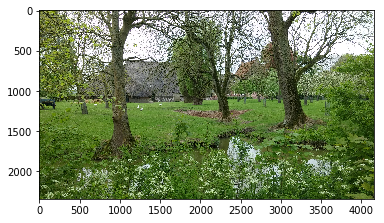

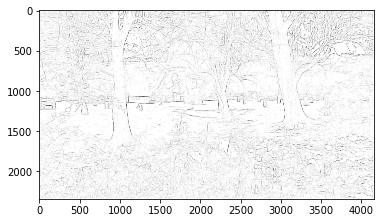

In [3]:
image = imageio.imread("data/test.jpg")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float32)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)

detector = cv2.ximgproc.createStructuredEdgeDetection("data/opencv_sed_model.yml.gz")
gradient_image = detector.detectEdges(image)
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image, hg.WeightFunction.max)

plt.imshow(image)
plt.figure()
plt.imshow(1 - gradient_image, cmap="gray")
plt.show()

In [4]:
if produce_illustrations:
    grd = gradient_image / np.max(gradient_image) * 255
    grd = grd.astype(np.uint8)
    grd = 255 - grd
    target_size = (int(image.shape[1]/8), int(image.shape[0]/8))
    grd = cv2.resize(grd, target_size)
    imageio.imsave(res_path + "test_grad.png", grd)
    imageio.imsave(res_path + "test.png", cv2.resize(image, target_size))

We will generate superpixels as horizontal cuts in a hierarchical watershed by area

In [5]:
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
ultrametric = hg.saliency(tree, altitudes)
tree, altitudes = hg.bpt_canonical(graph, ultrametric)
atltiudes = np.zeros((tree.num_vertices(),))
altitudes[tree.num_leaves():] = np.arange(1, tree.num_leaves())
hc = hg.HorizontalCutExplorer(tree, altitudes)

Number of regions 1000
Number of regions 2500
Number of regions 5000
Number of regions 7500
Number of regions 10000
Number of regions 25000
Number of regions 50000


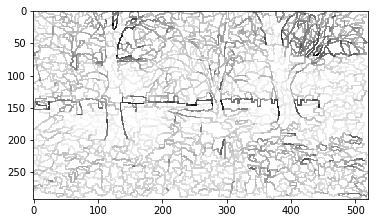

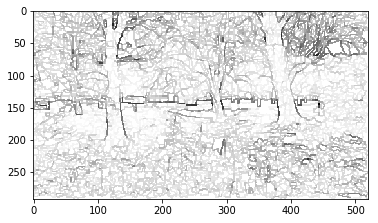

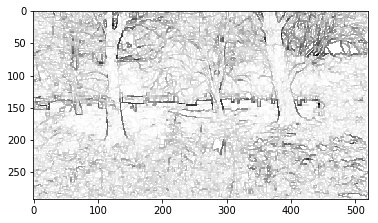

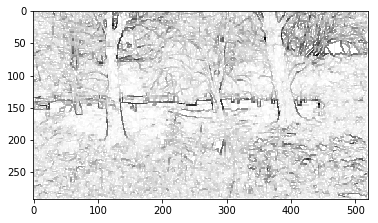

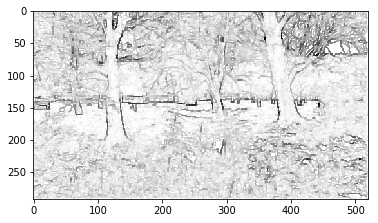

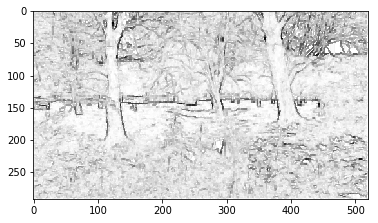

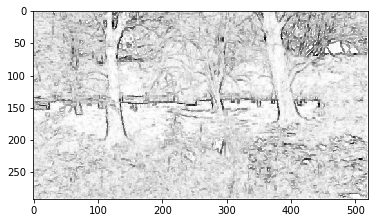

In [6]:
for s in sizes:
    print("Number of regions", s)
    cut = hc.horizontal_cut_from_num_regions(s)
    c = cut.graph_cut(tree)
    rag = hg.make_region_adjacency_graph_from_graph_cut(graph, c)
    rag_edge_weights = hg.rag_accumulate_on_edges(rag, hg.Accumulators.mean, edge_weights)
    
    name = res_path + "rag_" + str(rag.num_vertices()) + "_" + str(rag.num_edges()) + ".graph"
    hg.save_graph_pink(name, rag, edge_weights=rag_edge_weights)
    
    if produce_illustrations:
        im = hg.graph_4_adjacency_2_khalimsky(graph, hg.rag_back_project_edge_weights(rag, rag_edge_weights))
        im = (im / np.max(im)) * 255
        im = im.astype(np.uint8)
        kernel = np.ones((3,3), np.uint8) 
        im = cv2.dilate(im, kernel, iterations=16) 

        im = 255 - im 
        im = cv2.resize(im, target_size)
        imageio.imsave(res_path + "rag_" + str(rag.num_vertices()) + "_" + str(rag.num_edges()) + ".png", im)
        plt.figure()
        plt.imshow(im, cmap='gray')

# Closest ultrametric

In [7]:
from ultrametric.optimization import UltrametricFitting
from ultrametric.loss import loss_closest

In [8]:
from glob import glob
import time
files = glob(res_path + "*.graph")

for f in files:
    graph, _, edge_weights = hg.read_graph_pink(f)
    optim = UltrametricFitting(500, 0.1, loss_closest)
    
    start = time.time()
    ultrametric = optim.fit(graph, edge_weights)
    stop = time.time()
    total_time = stop - start
    
    history = optim.history
    num_iterations = len(history)
    time_per_iteration = total_time / num_iterations
    
    print("Graph size (%d, %d)"%(graph.num_vertices(), graph.num_edges()))
    loss = np.sum((ultrametric - edge_weights) ** 2)
    print("\tFinal loss: %f"%(loss, ))
    print("\tNumber of iterations: %d"%(num_iterations, ))
    print("\tTotal time: %f seconds"%(total_time, ))
    print("\tTime per iteration: %f seconds"%(time_per_iteration, ))
    

Graph size (10000, 29672)
	Final loss: 82.695490
	Number of iterations: 86
	Total time: 2.107083 seconds
	Time per iteration: 0.024501 seconds
Graph size (1000, 2955)
	Final loss: 10.038884
	Number of iterations: 81
	Total time: 0.184761 seconds
	Time per iteration: 0.002281 seconds
Graph size (25000, 73760)
	Final loss: 198.687285
	Number of iterations: 90
	Total time: 9.256765 seconds
	Time per iteration: 0.102853 seconds
Graph size (2500, 7417)
	Final loss: 23.188100
	Number of iterations: 82
	Total time: 0.516385 seconds
	Time per iteration: 0.006297 seconds
Graph size (50000, 146732)
	Final loss: 389.167993
	Number of iterations: 93
	Total time: 21.190127 seconds
	Time per iteration: 0.227851 seconds
Graph size (5000, 14837)
	Final loss: 44.425884
	Number of iterations: 84
	Total time: 0.961083 seconds
	Time per iteration: 0.011441 seconds
Graph size (7500, 22266)
	Final loss: 63.325873
	Number of iterations: 85
	Total time: 1.442957 seconds
	Time per iteration: 0.016976 seconds
